<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/signal_kalman_nifty_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [5]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [6]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [ ]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

In [8]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [9]:
df_kalman = pd.DataFrame(nlst).T

In [10]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [11]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [12]:
final_kalman=macd_calc(df_kalman)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragme

In [ ]:
final_kalman.tail(2)

In [14]:
features = final_kalman.columns.tolist()

In [15]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [16]:
final_dataframe=final_kalman[feats_set1]

In [17]:
solution=np.sign(final_dataframe)

In [18]:
solution['final']=solution.sum(axis=1)

In [ ]:
solution.tail(2)

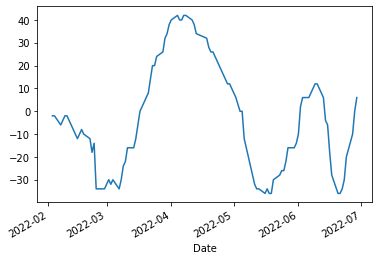

In [20]:
solution.final[-100:].plot();

In [21]:
solution['avg_mov']=solution['final'].rolling(window=10).mean()
nifty['avg_mov']=nifty['Adj Close'].rolling(window=22).mean()

In [22]:
l=1400

In [23]:
nifty['spread']=nifty['Close']-nifty['avg_mov']

In [24]:
nifty=nifty[-l:]
solution=solution[-l:]

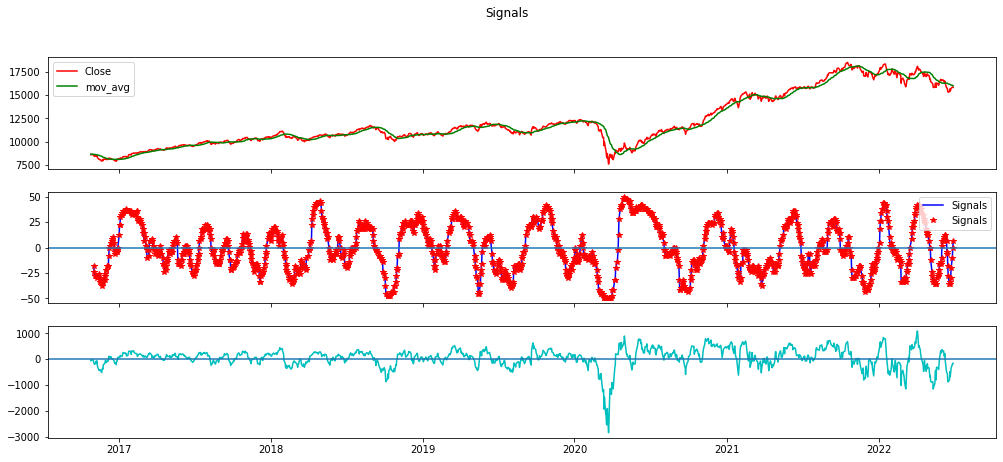

In [25]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'avg_mov'],'g', label='mov_avg')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
ax[2].plot(nifty.loc[:, :].index,nifty.loc[:,'spread'],'c',label='Spread')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
ax[2].axhline(y=0)
plt.show()

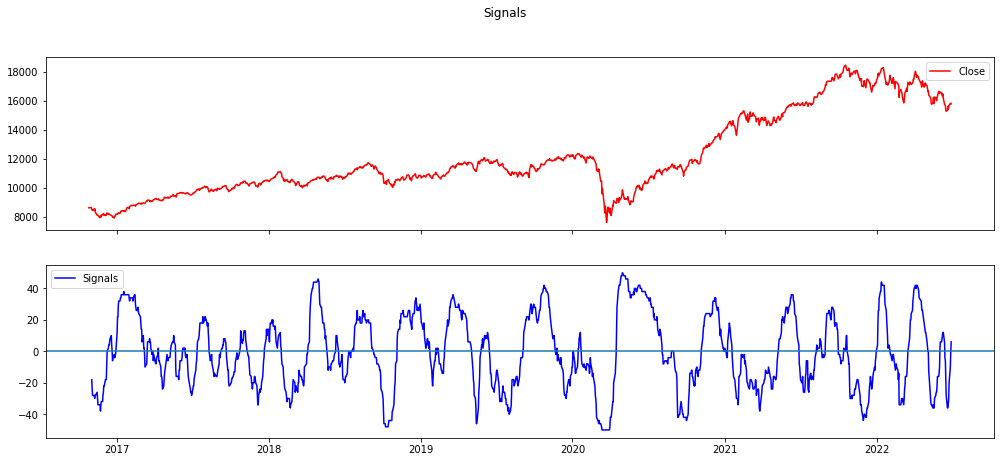

In [26]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
#ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'avg_mov'], label='Moving_Average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [27]:
l=400

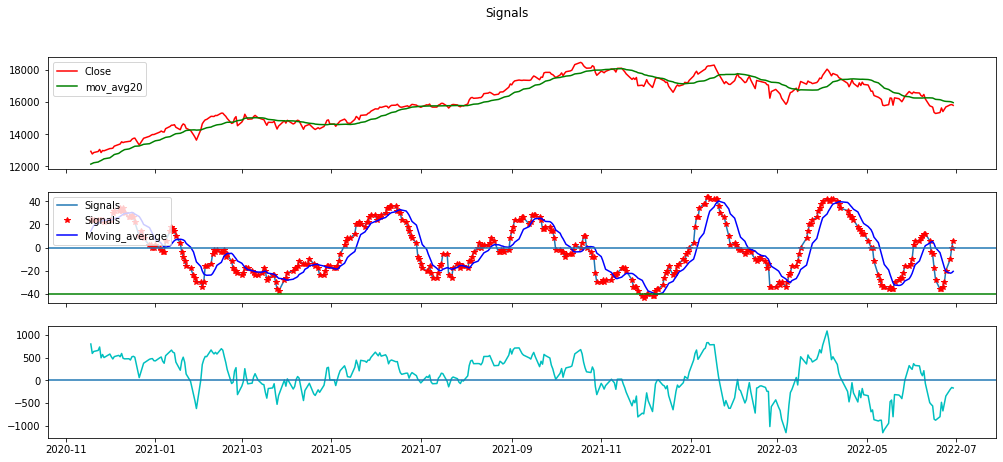

In [28]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='mov_avg20')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

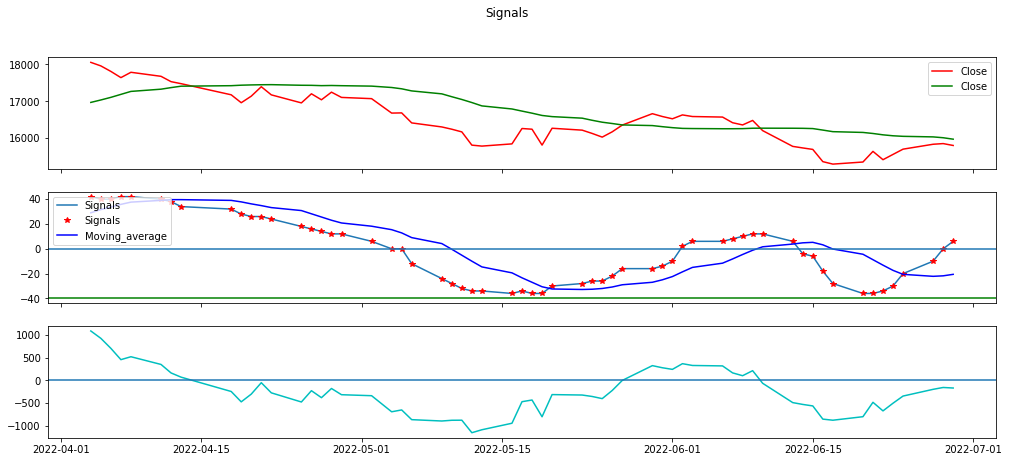

In [29]:
l=60
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='Close')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')

plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

In [30]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [31]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal changed to : 1


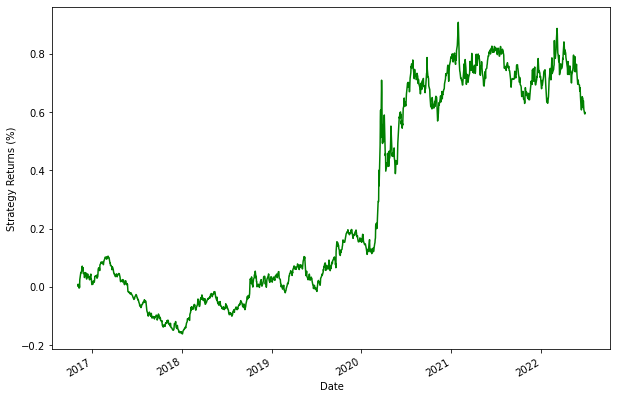

sharpe ratio :  0.04326954245822879
sortino ratio :  0.36944830226774744


In [32]:
# Calculate daily returns
nifty['Return'] = nifty.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * solution.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)

std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05)/std_neg
print('sortino ratio : ' , sortino_ratio)

In [33]:
def max_drawdown(return_series):
    comp_ret =return_series
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()
geometric_returns=pd.DataFrame(geometric_returns)

max_drawdowns= geometric_returns.apply(max_drawdown)
print('max_drawdown : ' , max_drawdowns)

max_drawdown :  Strategy_F   -2.517322
dtype: float64


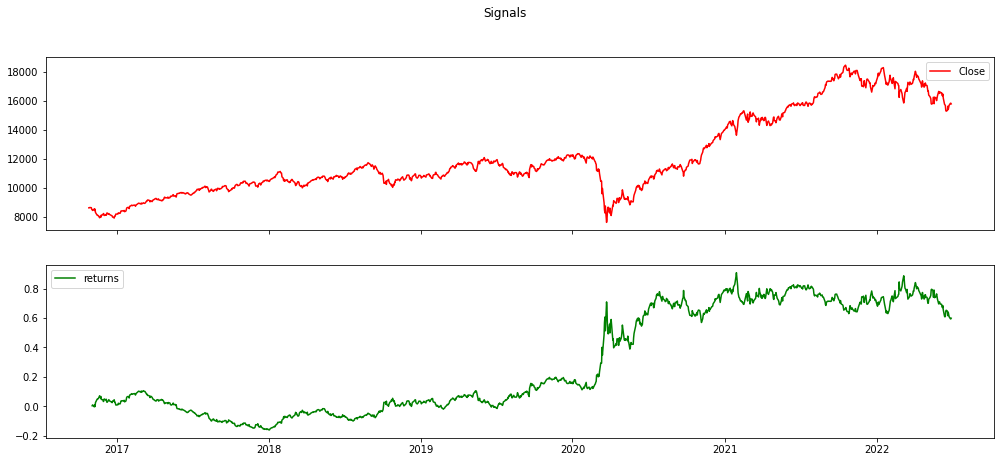

In [34]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(geometric_returns.index,geometric_returns,'g', label='returns')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
plt.show()

In [35]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,spread,Return,Strategy_F
Date,,,,,,,,,,
2022-06-28,15757.450195,15892.099609,15710.150391,15850.200195,15850.200195,251900,16008.918279,-158.718084,0.001146,-0.001146
2022-06-29,15701.700195,15861.599609,15687.799805,15799.099609,15799.099609,0,15969.722789,-170.623180,-0.003224,0.003224


In [36]:
print('change in nifty from yesterday' ,(nifty.Close.iloc[-1]-nifty.Close.iloc[-2])/nifty.Close.iloc[-2]*100)

change in nifty from yesterday -0.3223971010322782
